In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imshow
from sklearn.decomposition import PCA
import warnings
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
warnings.filterwarnings("ignore")

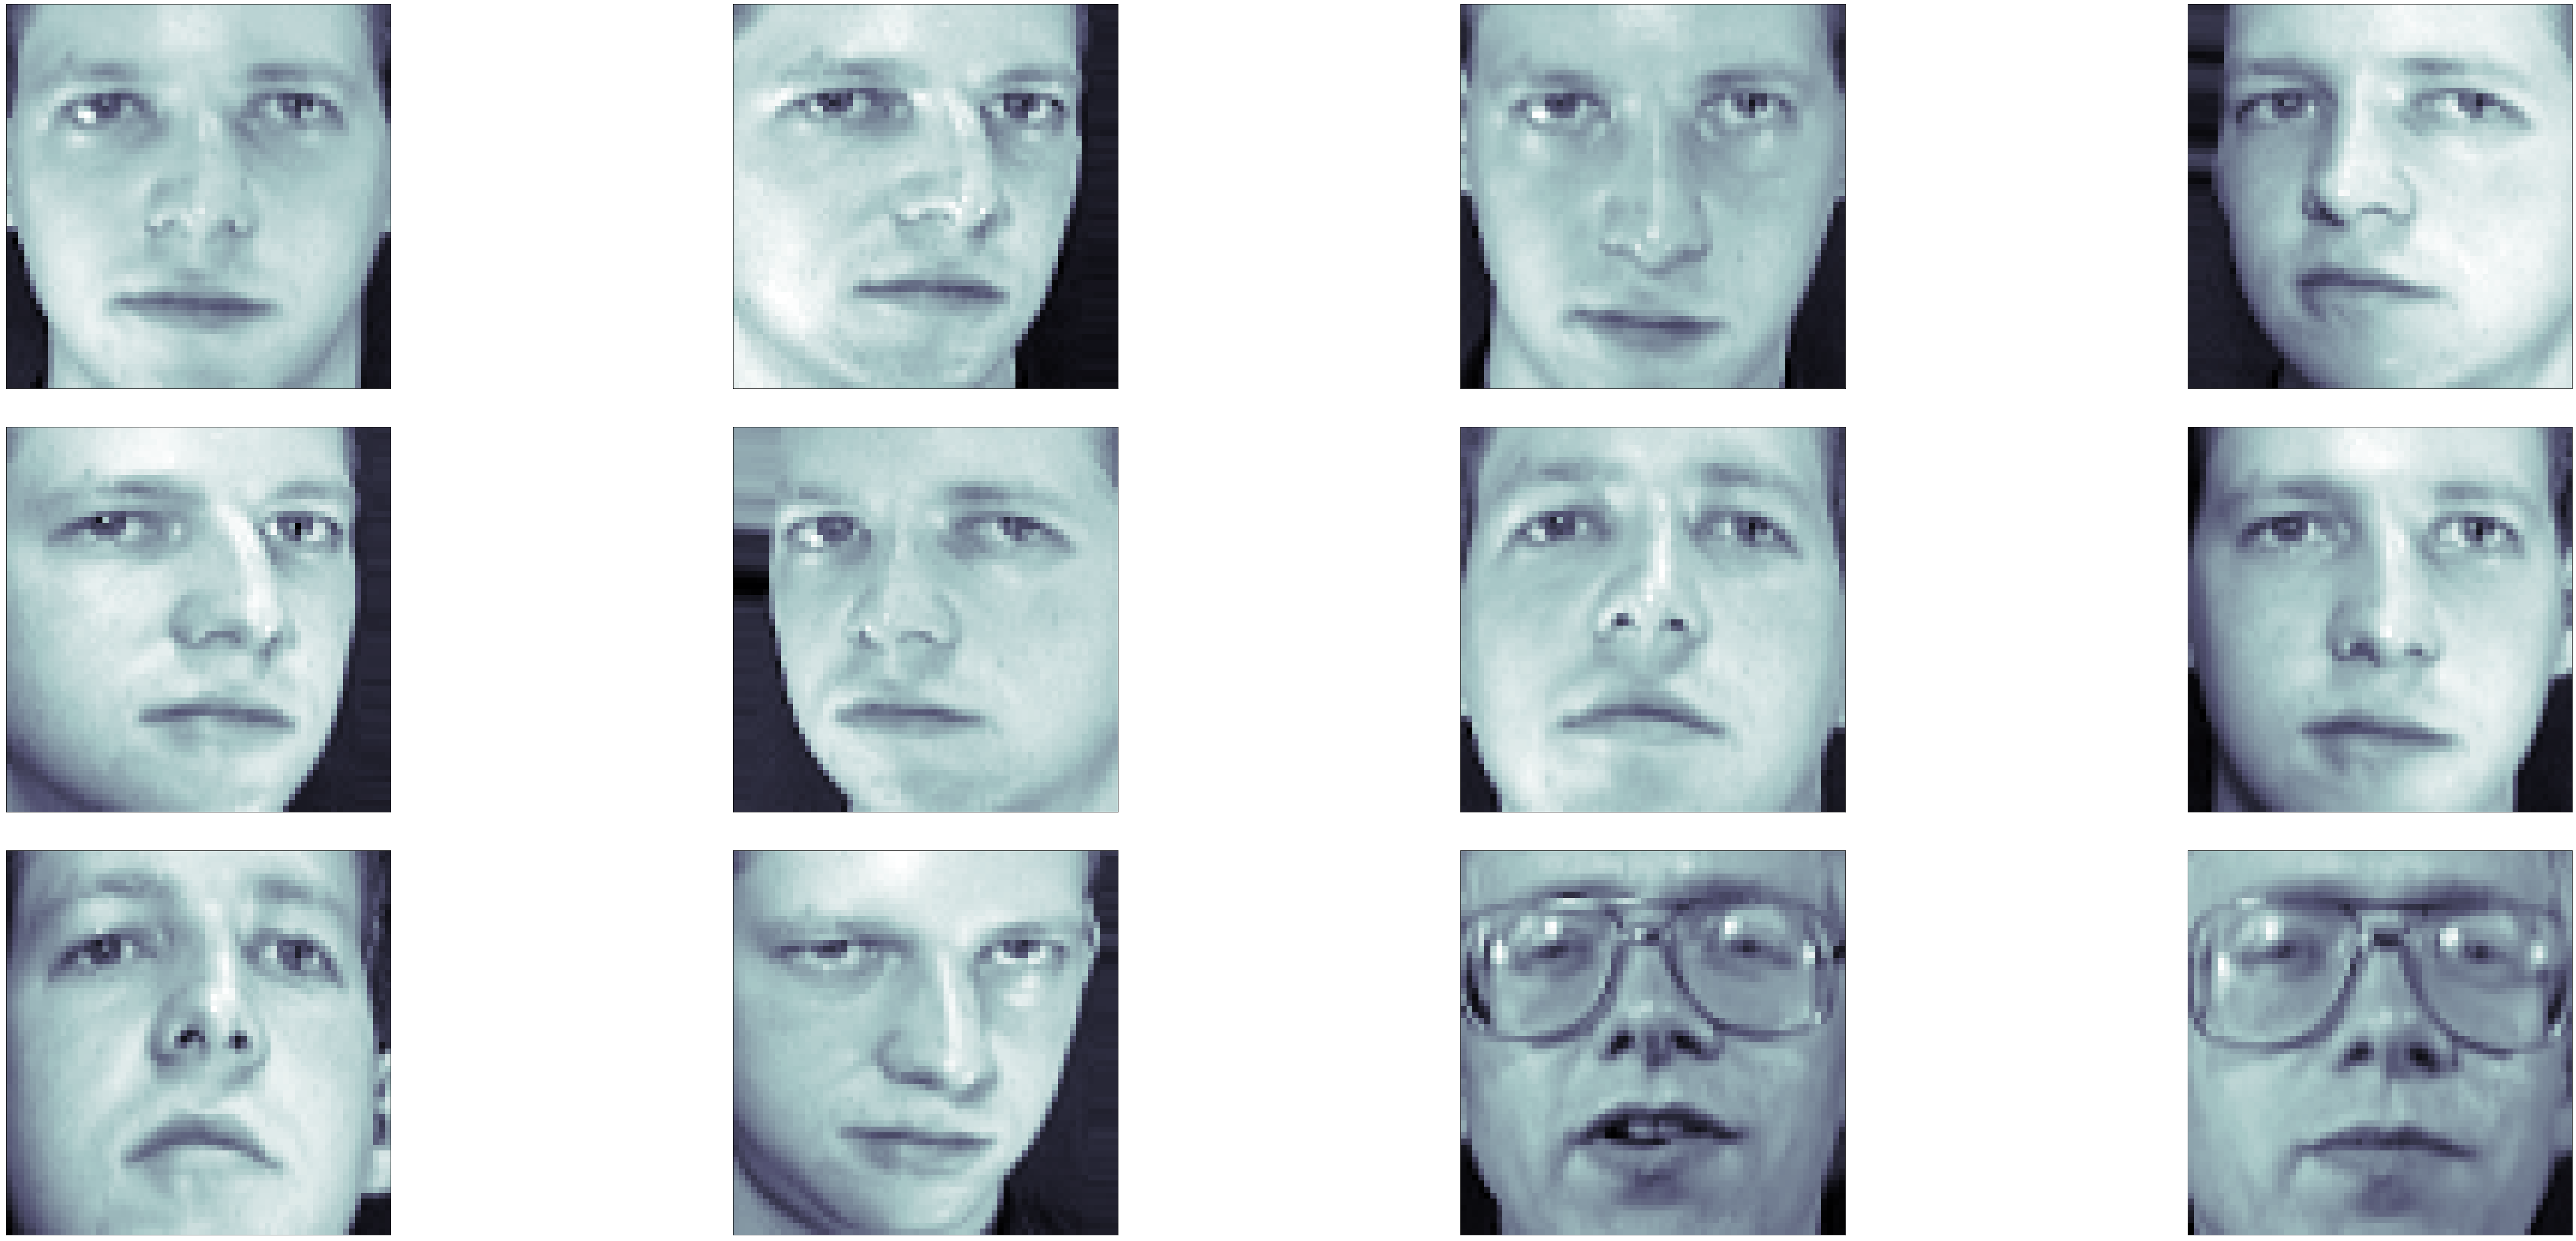

In [2]:
# load dataset.
faces_image = np.load('olivetti_faces.npy')

# show dataset.
fig, axes = plt.subplots(3, 4, figsize=(90, 40),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(faces_image[i], cmap='bone')

400 64 64


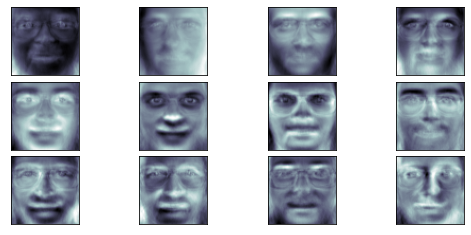

In [3]:
# use PCA to do face dimensionality reduction.
n_components = 90
def face_pca(faces, n_components):
    h = faces.shape[1]
    w = faces.shape[2]
    print(faces.shape[0], faces.shape[1], faces.shape[2])
    
    faces_data = faces.reshape(faces.shape[0], h*w)
    
    pca = PCA(n_components = n_components).fit(faces_data)
    
    faces_pca = pca.transform(faces_data)
    eigen_faces = pca.components_.reshape((n_components, h, w))
    
    return faces_pca, eigen_faces

    
faces_pca, eigen_faces = face_pca(faces_image, n_components)

# faces_data: 400x4096
# eigen_data: 150x4096
# faces_pca: 150x4096
                
# Show eigen faces
fig, axes = plt.subplots(3, 4, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigen_faces[i], cmap='bone')

In [5]:
# Implement k-means.
# k = 40
class KMeans():
    def __init__(self, k=40, max_iter=500):
        self.k = k
        self.max_iter = max_iter
       
        self.label = None
    
    def _dist(self, a, b):
        
        return np.math.sqrt(sum(np.power(a - b, 2)))
    
    def _randCenter(self, data, k):
        r = data.shape[1]
        centers = np.empty((k, r))  
        for i in range(r):
            min_Value = min(data[:, i])
            max_Value = max(data[:, i])
            centers[:, i] = (min_Value + (max_Value - min_Value) * np.random.rand(k, 1)).flatten()
        return centers
    
        
    def fit(self, data):
       
        n = data.shape[0] 
        a_cluster = np.zeros(n) 
        d_cluster = np.full(n, np.inf) 
        
        centers = self._randCenter(data, self.k)
        
        for _ in range(self.max_iter):
            cluster1 = False
            for i in range(n):
                min_distance = np.inf
                min_index = -1

                for j in range(self.k):
                    center = centers[j, :]
                    sample = data[i, :]
                    dis = self._dist(center, sample)
                    if dis < min_distance:
                        min_distance = dis
                        min_index = j
                
                if a_cluster[i] != min_index and d_cluster[i] > min_distance:
                    cluster1 = True
                    a_cluster[i] = min_index 
                    d_cluster[i] = min_distance

            if not cluster1:
                break
            
            for i in range(self.k):
                index = np.nonzero(a_cluster==i)[0]
                centers[i, :] = np.mean(data[index], axis=0)
        
        self.labels = a_cluster
        
# Clustering
cluster_num = 40
cluster = KMeans(k=cluster_num)
cluster.fit(faces_pca)

# Show the final results
labels = cluster.labels
for i in range(cluster_num):
    index1 = np.nonzero(labels==i)[0]
    num = len(index1)
    this_faces = faces_image[index1]
    fig, axes = plt.subplots(1, num, figsize=(4 * (num + 1), 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    fig.suptitle("Cluster " + str(i), fontsize=20)
    for i, ax in enumerate(axes.flat):
        ax.imshow(this_faces[i], cmap='bone')

Output hidden; open in https://colab.research.google.com to view.

In [6]:
score_SH = silhouette_score(faces_pca, cluster.labels, metric = 'euclidean')
score_SH

0.12327532

In [7]:
score_CH = calinski_harabasz_score(faces_pca, cluster.labels)
score_CH

16.883188043258954

In [8]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

In [9]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(faces_pca)
distances, indices = neighbors_fit.kneighbors(faces_pca)

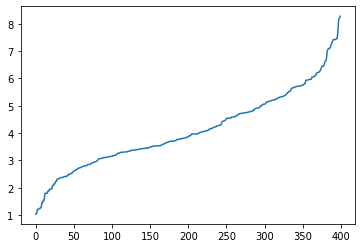

In [10]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

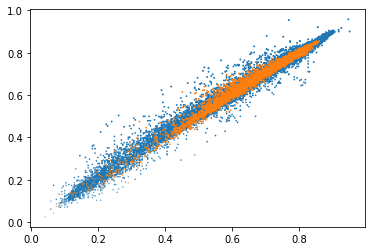

In [28]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN

# define the model
dbscan_model = DBSCAN(eps=7.311111112, min_samples= 72, algorithm='ball_tree', metric='minkowski', leaf_size=90, p=2 )

# train the model
dbscan_result = dbscan_model.fit(faces_pca)
label_s = dbscan_result.labels_

# assign each data point to a cluster
dbscan_result = dbscan_model.fit_predict(faces_pca)

# get all of the unique clusters
dbscan_clusters = unique(dbscan_result)
dbscan_clusters

# plot the DBSCAN clusters
for dbscan_cluster in dbscan_clusters:
    # get data points that fall in this cluster
    index = where(dbscan_result == dbscan_cluster)
    # make the plot
    pyplot.scatter(faces_image[index, 0], faces_image[index, 1], faces_image[index, 2])

# # show the DBSCAN plot
# pyplot.show()

In [21]:
score_SH = silhouette_score(faces_pca, label_s)
score_SH

-0.067350276

In [22]:
score_CH = calinski_harabasz_score(faces_pca, label_s)
score_CH

5.285712443507121